# Análisis Exploratorio de Datos - Mercado Inmobiliario

Este cuaderno realiza la limpieza, análisis exploratorio y regresion lineal de los datos scrapeados de ZonaProp.

## 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración de estilo
sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

## 1. Carga de Datos
En esta sección cargaremos los datos desde el archivo CSV.

In [2]:
# Leemos el dataset
try:
    df = pd.read_csv("../data/raw/real_estate_listings.csv")
    print(f"Dimensiones iniciales: {df.shape}")
    display(df.head())
except FileNotFoundError:
    print("Archivo no encontrado. Verifica la ruta.")

Dimensiones iniciales: (29999, 6)


,price,location,features,expensas,description,url
0,USD 109.000,"Palermo, Capital Federal","['32 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 125.000 Expensas,"Departamento de dos ambientes con cocina separada por una barra, con espacio para lavarropas, heladera y cocina y anafe eléctricos. Living comedor con ventanal, baño completo y dormitorio con placard",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-hermoso-departamento-en-venta-de-dos-ambientes-en-56926847.html?n_src=Listado&n_pills=Encargado&n_pg=1&n_pos=1
1,USD 95.243,"Villa Devoto, Capital Federal","['39 m² tot.', '1 amb.', '1 baño', '1 coch.']",$ 50.000 Expensas,"Venta departamento monoambiente A estrenar en gabriela mistral 3400, villa devoto. 3er piso al contrafrente. ubicaciónsituado en el exclusivo barrio de villa devoto, este departamento ofrece una ubica",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-3-ambientes-a-estrenar-villa-devoto-56759252.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=2
2,USD 190.000,"Villa Urquiza, Capital Federal","['62 m² tot.', '2 amb.', '1 dorm.', '1 baño']",$ 1 Expensas,"Edificio Atrium Boulevard en esquina ubicado en la mejor zona de Villa Urquiza, con vista abierta frente al privilegiado Boulevard Mendoza. Ofrece unidades exclusivas con parrilla propia, además cuent",https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-dos-ambientes-con-espectacular-terraza-propia!-57749158.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=3
3,USD 133.984,"Belgrano, Capital Federal","['78 un.', '1 a 3 amb.', '35 a 169 m² tot.', 'Gimnasio', 'Parrilla', 'Pileta', 'Solarium', 'Balcón', 'Terraza']",NaN,"Imponente Proyecto de viviendas de gran categoría del Estudio Aisenson y mmp Desarrollos, ubicado en el corazón de Nuñez, con una excelente y céntrica ubicación en la Av. Cabildo con esquina Monroe, a",https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-cabildo-boulevard-2502-fecha-de-entrega-2027-54112197.html?n_src=Listado&n_pg=1&n_pos=4
4,USD 175.000,"Villa Urquiza, Capital Federal","['94 m² tot.', '2 amb.', '1 dorm.', '1 baño', '1 coch.']",$ 150.000 Expensas,Venta departamento unico de 2 ambientes con balcon terraza propia de 46 M2departamento con cocheralibre reformas por reglamente de copropiedad!! departamento excelente ubicacionno dejes de mirar el vi,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-2-ambientes-con-balcon-terraza-y-57626120.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=5


## 2. Limpieza y Procesamiento de Datos
En esta sección limpiaremos y procesaremos los datos para poder utilizarlos de forma apropiada.

In [18]:
# 1. Limpieza de strings
df['features_clean'] = df['features'].str.replace(r"[[\]']", "", regex=True)
# Aseguramos que la descripcion sea string para evitar errores con nulos
df['description'] = df['description'].fillna('')

# 2. Función de extracción general
def extract_opt(text, pattern):
    match = re.search(fr'(\d+)\s*(?:{pattern})', text, re.IGNORECASE)
    return int(match.group(1)) if match else 0

# 3. Extracción de features 
df['m2'] = df['features_clean'].apply(lambda x: extract_opt(x, 'm²|metros'))
df['ambientes'] = df['features_clean'].apply(lambda x: extract_opt(x, 'amb'))
df['baños'] = df['features_clean'].apply(lambda x: extract_opt(x, 'baños'))
df['dormitorios'] = df['features_clean'].apply(lambda x: extract_opt(x, 'dorm'))
df['cocheras'] = df['features_clean'].apply(lambda x: extract_opt(x, 'coch'))

# 4. Limpieza de precio 
df['precio_usd'] = pd.to_numeric(df['price'].str.replace(r'[^0-9]', '', regex=True), errors='coerce')

# 5. Filtrado y Limpieza Final
df_clean = df.dropna(subset=['precio_usd']).copy()
df_clean['ubicación'] = df_clean['location']

df_clean['baños'] = df_clean['baños'].replace(0,1)

cols_finales = ['precio_usd', 'ubicación', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'url']
df_clean = df_clean[cols_finales].fillna(0)

df_clean.head()

,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,url
0,109000.00,"Palermo, Capital Federal",32,2,1,1,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-hermoso-departamento-en-venta-de-dos-ambientes-en-56926847.html?n_src=Listado&n_pills=Encargado&n_pg=1&n_pos=1
1,95243.00,"Villa Devoto, Capital Federal",39,1,0,1,1,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-3-ambientes-a-estrenar-villa-devoto-56759252.html?n_src=Listado&n_pills=Luminoso&n_pg=1&n_pos=2
2,190000.00,"Villa Urquiza, Capital Federal",62,2,1,1,0,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-dos-ambientes-con-espectacular-terraza-propia!-57749158.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=3
3,133984.00,"Belgrano, Capital Federal",169,3,0,1,0,https://www.zonaprop.com.ar/propiedades/emprendimiento/ememvein-cabildo-boulevard-2502-fecha-de-entrega-2027-54112197.html?n_src=Listado&n_pg=1&n_pos=4
4,175000.00,"Villa Urquiza, Capital Federal",94,2,1,1,1,https://www.zonaprop.com.ar/propiedades/clasificado/veclapin-venta-departamento-2-ambientes-con-balcon-terraza-y-57626120.html?n_src=Listado&n_pills=Terraza&n_pg=1&n_pos=5


## 3. Análisis Exploratorio de Datos (EDA)
En esta sección generaremos nuevas variables y realizaremos un análisis exhaustivo de los datos inmobiliarios.

In [4]:
# 1. Feature Engineering: Creación de nuevas variables

# Precio por m2 (Dólares / m2)
# Filtramos propiedades con m2 > 0 para evitar divisiones por cero
df_clean = df_clean[df_clean['m2'] > 0].copy()
df_clean['precio_m2'] = df_clean['precio_usd'] / df_clean['m2']

# Relación cantidad de ambientes por m2
df_clean['ambientes_m2'] = df_clean['ambientes'] / df_clean['m2']

# Extracción del nombre del Barrio desde la columna 'ubicación'
df_clean['barrio'] = df_clean['ubicación'].apply(lambda x: x.split(',')[0].strip() if isinstance(x, str) else 'Desconocido')

print(f"Cantidad de barrios identificados: {df_clean['barrio'].nunique()}")
print("Variables creadas: precio_m2, ambientes_m2, barrio")
display(df_clean[['ubicación', 'barrio', 'precio_usd', 'm2', 'precio_m2']].head())

Cantidad de barrios identificados: 82
Variables creadas: precio_m2, ambientes_m2, barrio


,ubicación,barrio,precio_usd,m2,precio_m2
0,"Palermo, Capital Federal",Palermo,109000.00,32,3406.25
1,"Villa Devoto, Capital Federal",Villa Devoto,95243.00,39,2442.13
2,"Villa Urquiza, Capital Federal",Villa Urquiza,190000.00,62,3064.52
3,"Belgrano, Capital Federal",Belgrano,133984.00,169,792.80
4,"Villa Urquiza, Capital Federal",Villa Urquiza,175000.00,94,1861.70


### 3.1 Identificación de Valores Atípicos (Outliers)
Visualizamos la distribución de las variables clave para detectar valores extremos que puedan sesgar el análisis.

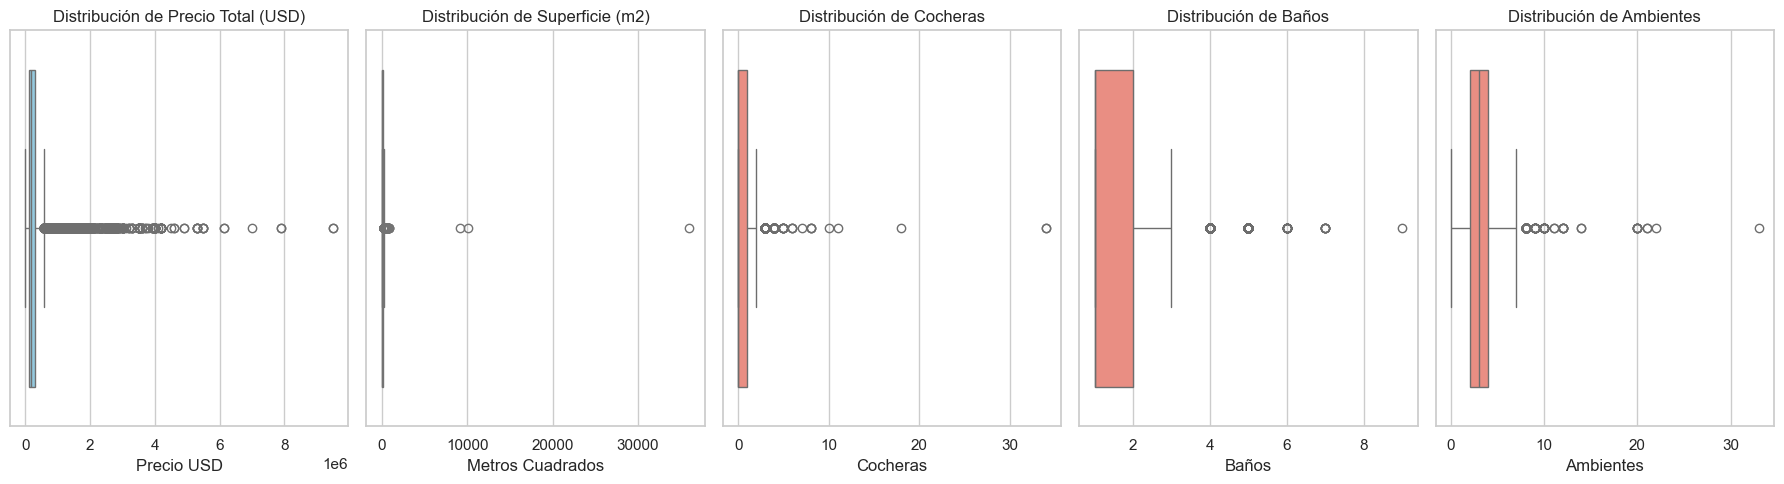

In [5]:
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Cocheras
sns.boxplot(x=df_clean['cocheras'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Cocheras')
axes[2].set_xlabel('Cocheras')

# Boxplot Baños
sns.boxplot(x=df_clean['baños'], ax=axes[3], color='salmon')
axes[3].set_title('Distribución de Baños')
axes[3].set_xlabel('Baños')

# Boxplot Ambientes
sns.boxplot(x=df_clean['ambientes'], ax=axes[4], color='salmon')
axes[4].set_title('Distribución de Ambientes')
axes[4].set_xlabel('Ambientes')

plt.tight_layout()
plt.show()


### 3.2 Limpieza de Outliers

Se identificaron 0 propiedades como outliers extremos.


,precio_usd,ubicación,m2,ambientes,dormitorios,baños,cocheras,expensas,url,precio_m2,ambientes_m2,barrio,tiene_cochera,log_precio


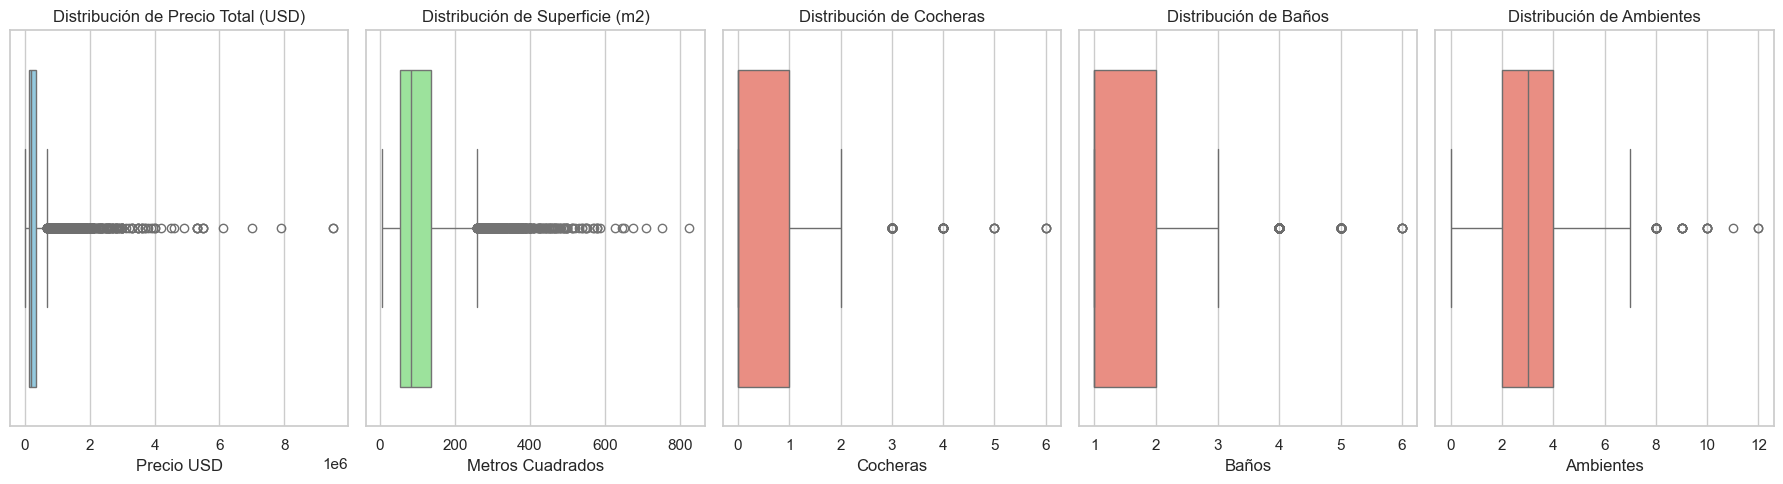

In [17]:
# Identificar Outliers
# Creamos un filtro para identificar outliers
filtro_outliers = (
    (df_clean['precio_usd'] < 20000) |  
    (df_clean['m2'] > 5000) | 
    (df_clean['cocheras'] > 6) | 
    (df_clean['baños'] > 6) | 
    (df_clean['ambientes'] > 12) | 
    (df_clean['barrio'] == 'Otro')
    )

df_outliers = df_clean[filtro_outliers]

print(f"Se identificaron {len(df_outliers)} propiedades como outliers extremos.")
display(df_outliers.head(10))

# Extraer urls
urls_outliers = df_outliers['url']
for url in urls_outliers:
    print(url)

# Eliminar outliers
df_clean = df_clean.drop(df_outliers.index)

# Eliminar duplicados
df_clean = df_clean.drop_duplicates(subset=['precio_m2'], keep='first')

# Comprobación
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

# Boxplot Precio Total
sns.boxplot(x=df_clean['precio_usd'], ax=axes[0], color='skyblue')
axes[0].set_title('Distribución de Precio Total (USD)')
axes[0].set_xlabel('Precio USD')

# Boxplot Superficie
sns.boxplot(x=df_clean['m2'], ax=axes[1], color='lightgreen')
axes[1].set_title('Distribución de Superficie (m2)')
axes[1].set_xlabel('Metros Cuadrados')

# Boxplot Cocheras
sns.boxplot(x=df_clean['cocheras'], ax=axes[2], color='salmon')
axes[2].set_title('Distribución de Cocheras')
axes[2].set_xlabel('Cocheras')

# Boxplot Baños
sns.boxplot(x=df_clean['baños'], ax=axes[3], color='salmon')
axes[3].set_title('Distribución de Baños')
axes[3].set_xlabel('Baños')

# Boxplot Ambientes
sns.boxplot(x=df_clean['ambientes'], ax=axes[4], color='salmon')
axes[4].set_title('Distribución de Ambientes')
axes[4].set_xlabel('Ambientes')

plt.tight_layout()
plt.show()


### 3.3 Segmentación Geográfica
Analizamos el precio promedio y el valor del m² agrupados por barrio. Esto permite identificar zonas premium y oportunidades de inversión.

Top 10 Barrios más caros por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Puerto Madero,989285.19,6115.65,302
Barrio Parque,1541900.00,5741.82,10
Palermo Nuevo,824222.26,4755.20,35
Palermo Chico,878449.24,4639.63,194
Distrito Quartier,202166.67,3770.81,3
Belgrano Chico,492855.70,3730.83,10
Las Cañitas,380399.54,3563.46,180
Núñez,454443.82,3490.42,395
Palermo,427563.36,3360.95,675


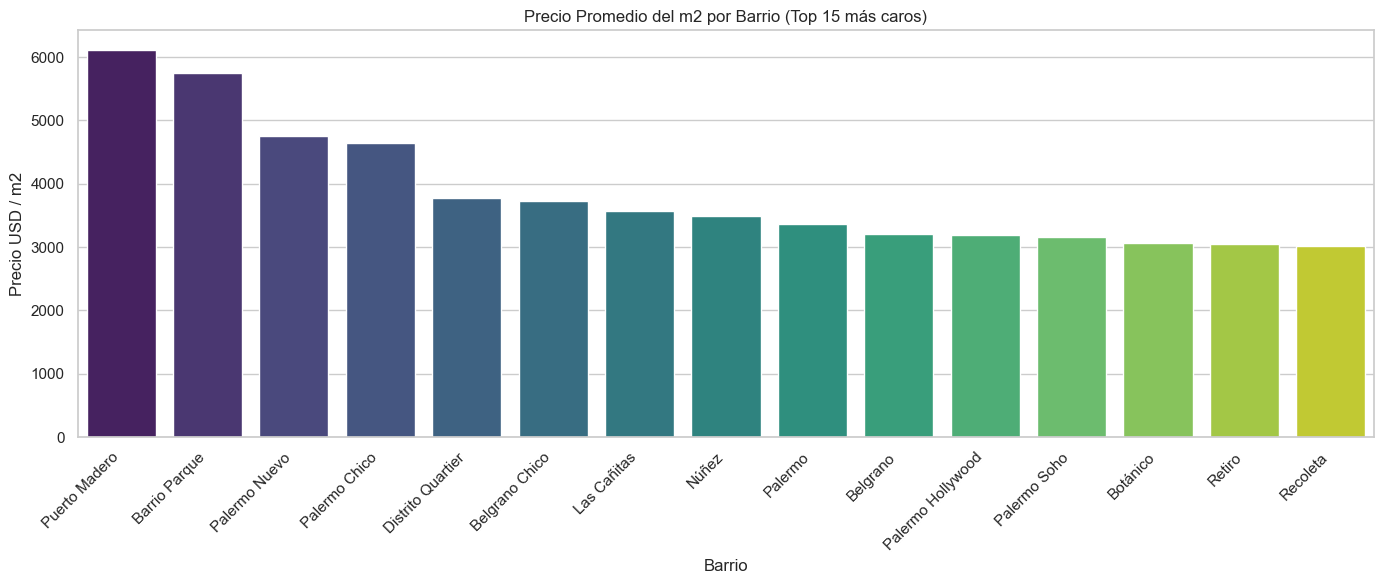

Top 10 Barrios más baratos por m2:


,precio_usd,precio_m2,cantidad
barrio,,,
Almagro Sur,126750.00,1092.79,2
Pompeya,58862.38,1166.23,8
Villa Soldati,85000.00,1229.02,3
Villa Lugano,86036.67,1256.62,33
Floresta,95518.18,1352.28,22
Floresta Norte,102633.33,1403.04,3
Tribunales,121250.00,1432.66,8
Constitución,86941.96,1464.89,25
Parque Avellaneda,103583.33,1500.94,6


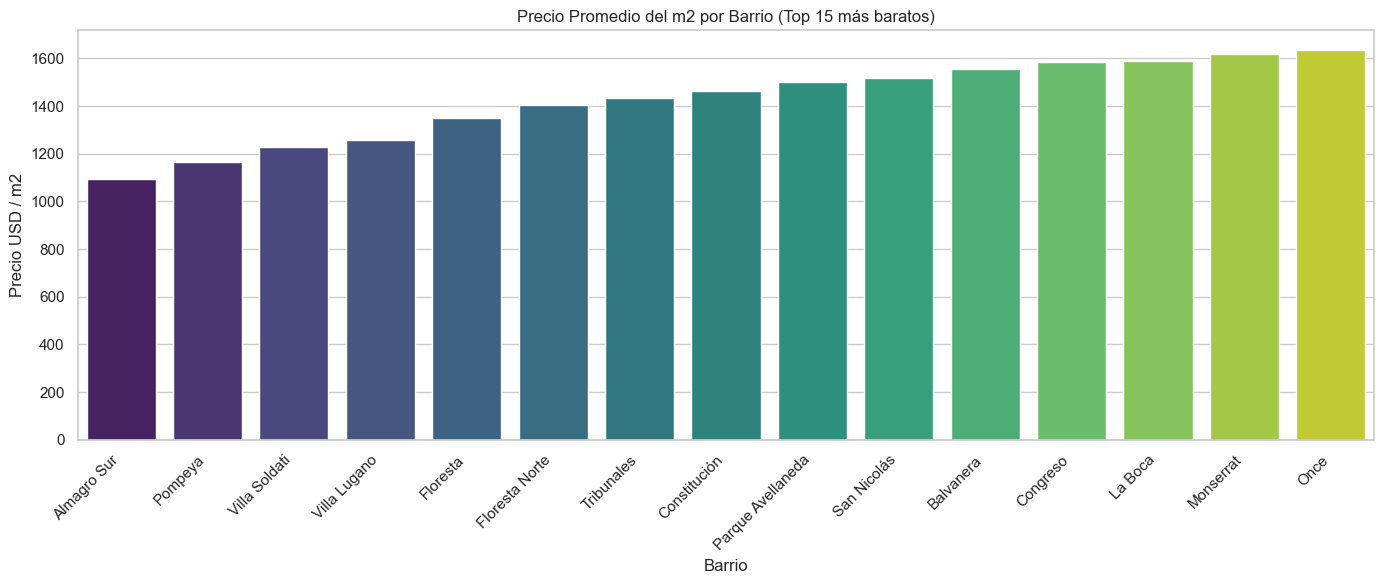

In [7]:
# Agrupamos por barrio y calculamos medias
barrio_stats = df_clean.groupby('barrio').agg({
    'precio_usd': 'mean',
    'precio_m2': 'mean',
    'ubicación': 'count' 
}).rename(columns={'ubicación': 'cantidad'}).sort_values('precio_m2', ascending=False)

# Filtramos solo barrios con una cantidad mínima representativa de datos
barrio_stats = barrio_stats[barrio_stats['cantidad'] > 0]

print("Top 10 Barrios más caros por m2:")
display(barrio_stats.head(10))

# Visualización de los Top 15 Barrios por Precio m2
plt.figure(figsize=(14, 6))
top_barrios = barrio_stats.head(15)
sns.barplot(x=top_barrios.index, y=top_barrios['precio_m2'], hue=top_barrios.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15 más caros)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

print("Top 10 Barrios más baratos por m2:")
barrios_baratos = barrio_stats.sort_values('precio_m2', ascending=True).head(15)
display(barrios_baratos)

# Visualización de los Top 15 Barrios más baratos por Precio m2
plt.figure(figsize=(14, 6))
barrios_baratos.head(15)
sns.barplot(x=barrios_baratos.index, y=barrios_baratos['precio_m2'], hue=barrios_baratos.index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio Promedio del m2 por Barrio (Top 15 más baratos)')
plt.ylabel('Precio USD / m2')
plt.xlabel('Barrio')
plt.tight_layout()
plt.show()

### 3.4 Drivers de Valor: Impacto de Cocheras y Baños
Evaluamos cómo la presencia de cochera y la cantidad de baños influyen en el precio de la propiedad.

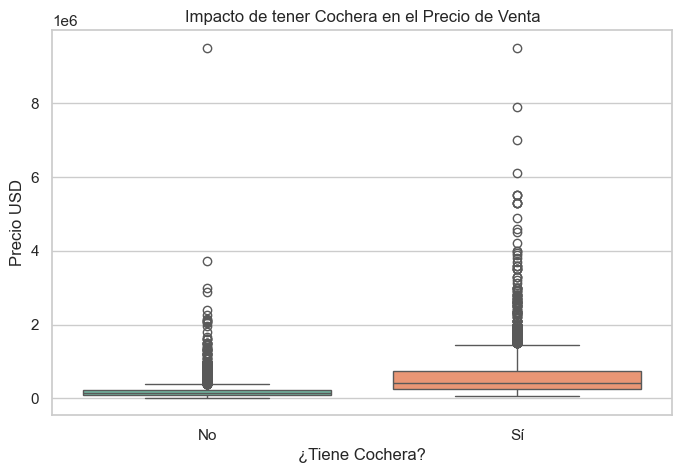

In [8]:
# Crear variable categórica para 'Tiene Cochera'
df_clean['tiene_cochera'] = df_clean['cocheras'].apply(lambda x: 'Sí' if x > 0 else 'No')

# Visualización: Precio vs Cochera
plt.figure(figsize=(8, 5))
sns.boxplot(x='tiene_cochera', y='precio_usd', data=df_clean, palette='Set2', hue='tiene_cochera')
plt.title('Impacto de tener Cochera en el Precio de Venta')
plt.ylabel('Precio USD')
plt.xlabel('¿Tiene Cochera?')
plt.show()


### 3.5 Matriz de Correlación
Analizamos la relación lineal entre las variables numéricas.

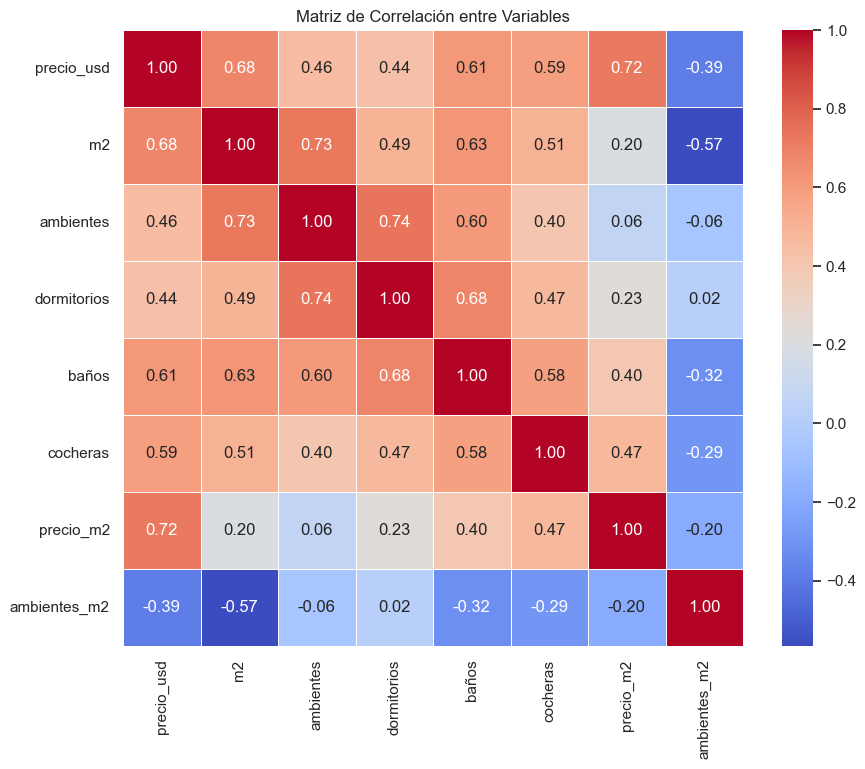

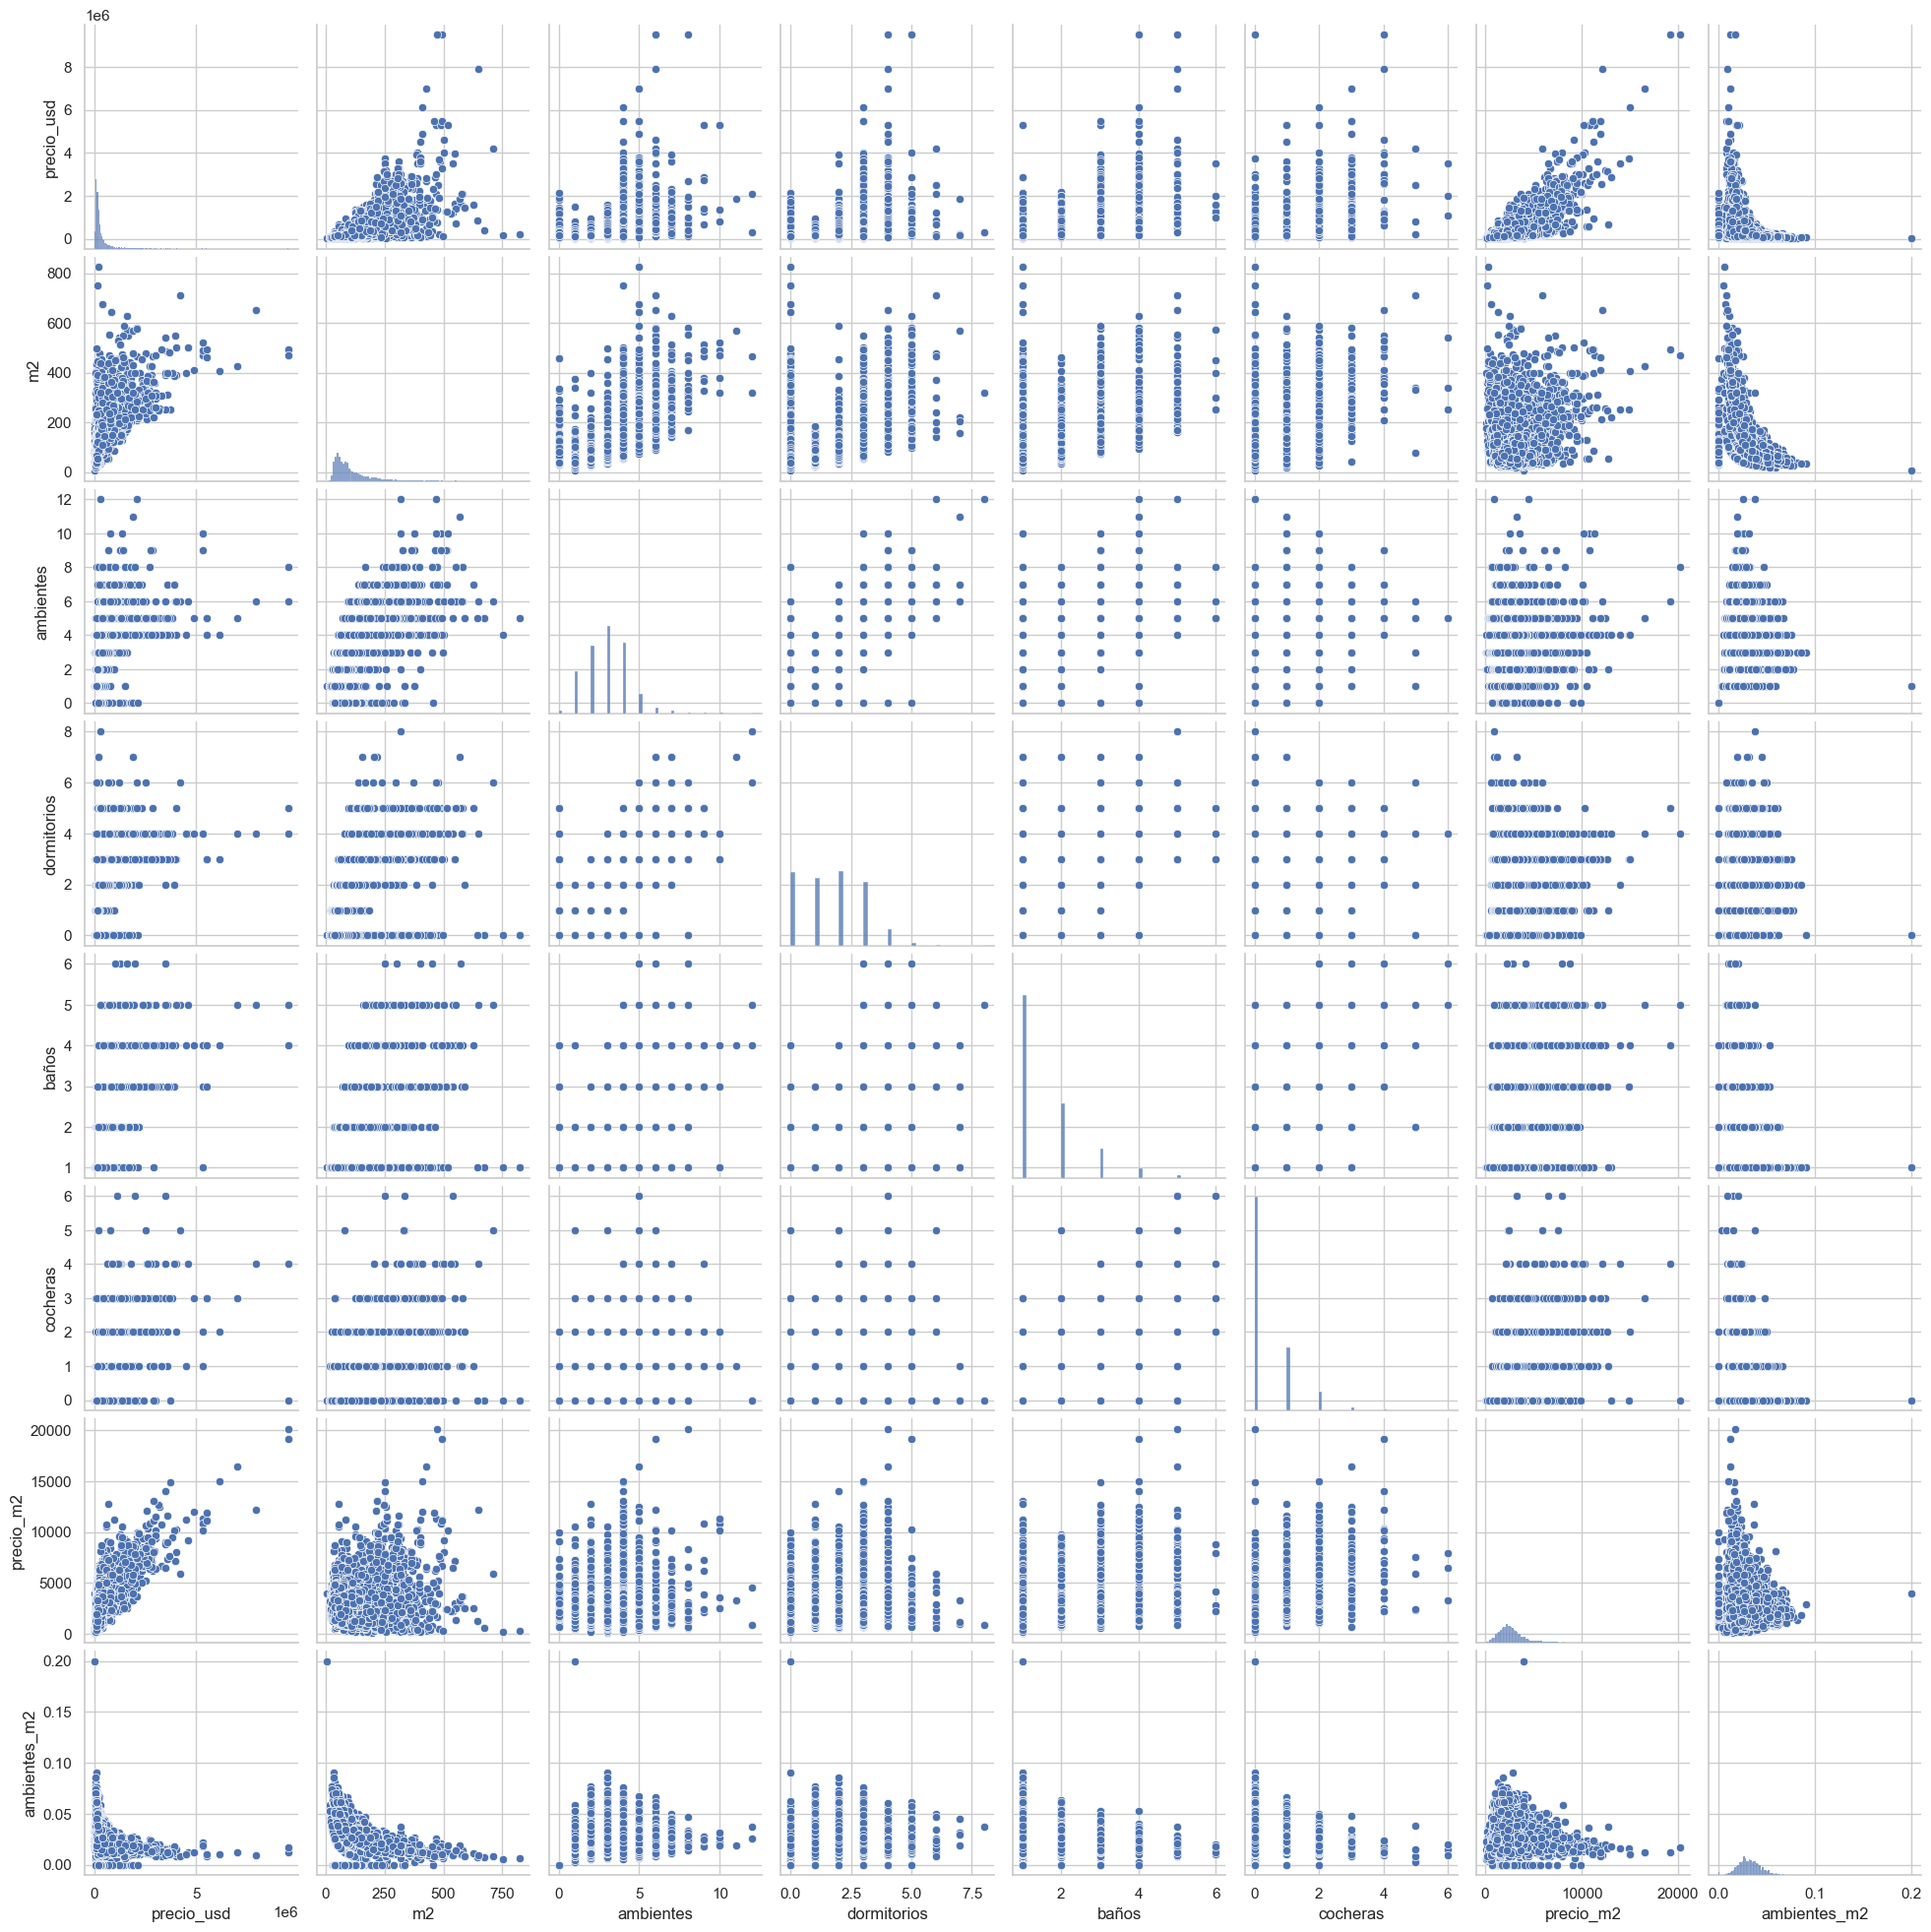

In [9]:
# Seleccionamos variables numéricas relevantes
vars_corr = ['precio_usd', 'm2', 'ambientes', 'dormitorios', 'baños', 'cocheras', 'precio_m2','ambientes_m2']
corr_matrix = df_clean[vars_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación entre Variables')
plt.show()

# Relaciones entre variables numéricas
sns.pairplot(df_clean)

## 4. Regresiones Lineales
Predicción del precio de una propiedad utilizando regresiones lineales

### Regresiones Lineales Simples

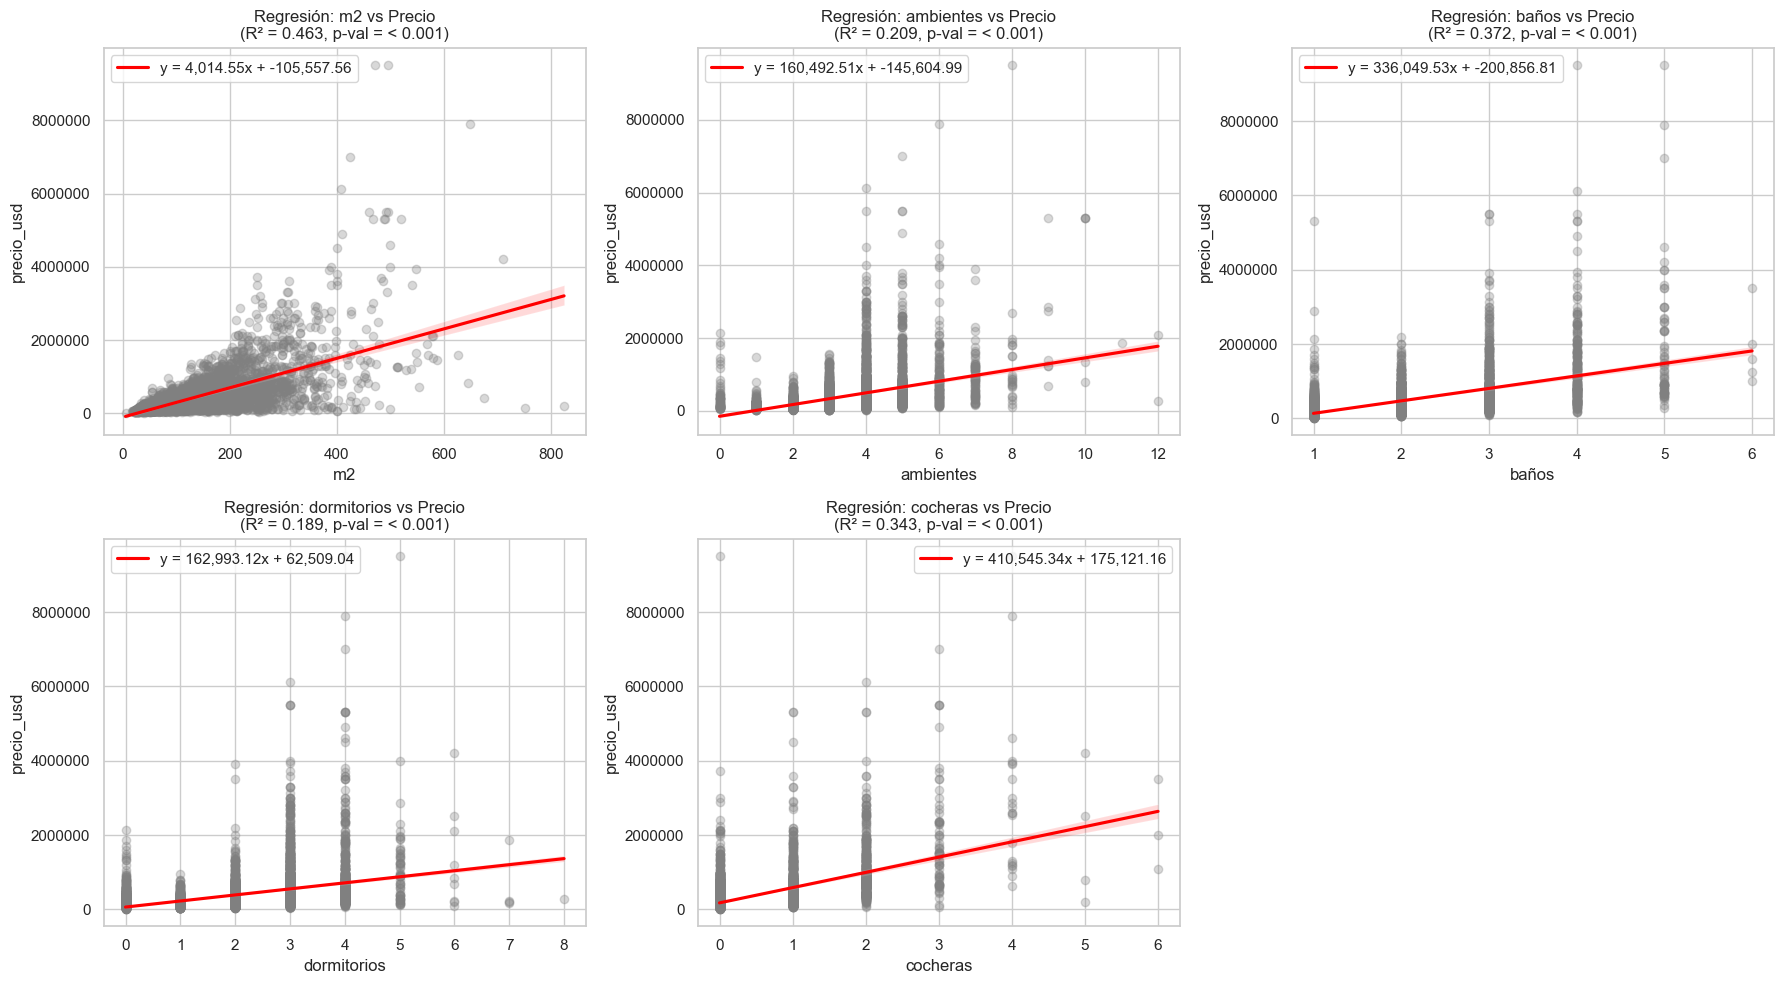

In [10]:
# Regresion Lineal Simple con R2 y p-value
variables = ['m2', 'ambientes', 'baños', 'dormitorios', 'cocheras']
target = 'precio_usd'

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    X_simple = sm.add_constant(df_clean[[var]])
    y = df_clean[target]
    
    model_simple = sm.OLS(y, X_simple).fit()
    
    intercepto = model_simple.params['const']
    pendiente = model_simple.params[var]
    r2 = model_simple.rsquared
    
    p_valor = model_simple.pvalues[var]
    
    p_texto = f"{p_valor:.3f}" if p_valor >= 0.001 else "< 0.001"
    
    sns.regplot(ax=axes[i], x=var, y=target, data=df_clean, 
                scatter_kws={'alpha':0.3, 'color':'gray'}, 
                line_kws={'color':'red', 'label':f'y = {pendiente:,.2f}x + {intercepto:,.2f}'})
    
    axes[i].set_title(f'Regresión: {var} vs Precio\n(R² = {r2:.3f}, p-val = {p_texto})')
    axes[i].legend()
    axes[i].ticklabel_format(style='plain', axis='y') 

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()


## 5. Regresiones Lineales Multiples 
Predicción del precio de una propiedad utiliando regresiones lineales multiples

### Regresion lineal multiple Log-Lin

#### Sin Variables Dummies

In [11]:
# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Selección de variables
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = df_clean[features]
X = sm.add_constant(X)

# 3. Verificación de VIF 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 4. Ajuste del Modelo Múltiple
modelo_log_sin_dummies= sm.OLS(df_clean['log_precio'], X).fit()

# 5. Resumen con Errores Estándar Robustos 
print(modelo_log_sin_dummies.get_robustcov_results(cov_type='HC3').summary())

Factores de Inflación de la Varianza (VIF):
     feature  VIF
0      const 6.92
1         m2 2.52
2      baños 2.10
3  ambientes 2.31
4   cocheras 1.59
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     2470.
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:32:41   Log-Likelihood:                -5305.0
No. Observations:                7952   AIC:                         1.062e+04
Df Residuals:                    7947   BIC:                         1.065e+04
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          t      P>|t|    

#### Con Varibles Dummies


In [12]:
# 1. Transformación Logarítmica (Soluciona Heterocedasticidad)
df_clean['log_precio'] = np.log(df_clean['precio_usd'])

# 2. Selección de variables y creación de variables dummy para 'barrio'
barrios_dummies = pd.get_dummies(df_clean['barrio'], prefix='barrio', drop_first=True)
features = ['m2', 'baños', 'ambientes', 'cocheras']
X = pd.concat([df_clean[features], barrios_dummies], axis=1).astype(float)
X = sm.add_constant(X)

# 3. Verificación de VIF 
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print("Factores de Inflación de la Varianza (VIF):")
print(vif_data)

# 4. Ajuste del Modelo Múltiple
modelo_log_con_dummies = sm.OLS(df_clean['log_precio'], X).fit()

# 5. Resumen con Errores Estándar Robustos 
print(modelo_log_con_dummies.get_robustcov_results(cov_type='HC3').summary())

Factores de Inflación de la Varianza (VIF):
                    feature    VIF
0                     const 334.76
1                        m2   2.64
2                     baños   2.14
3                 ambientes   2.48
4                  cocheras   1.69
..                      ...    ...
78        barrio_Villa Real   1.08
79  barrio_Villa Santa Rita   2.78
80     barrio_Villa Soldati   1.13
81     barrio_Villa Urquiza  13.43
82  barrio_Villa del Parque   6.52

[83 rows x 2 columns]
                            OLS Regression Results                            
Dep. Variable:             log_precio   R-squared:                       0.781
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     267.2
Date:                Fri, 16 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:32:45   Log-Likelihood:                -3793.2
No. Observations:                7952  

### Predicción

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Seleccionar variables numéricas para el modelo
X = df_clean[['m2', 'baños', 'ambientes', 'cocheras']]
y = df_clean['precio_usd']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")


Mean Absolute Error: 117894.63268344036
R2 Score: 0.690346291356249


## 6. Verificación y Mejora del Modelo de Regresión Lineal
Nos enfocaremos en validar los supuestos de la regresión lineal para asegurar que las conclusiones sean válidas.

### Residuos y normalidad

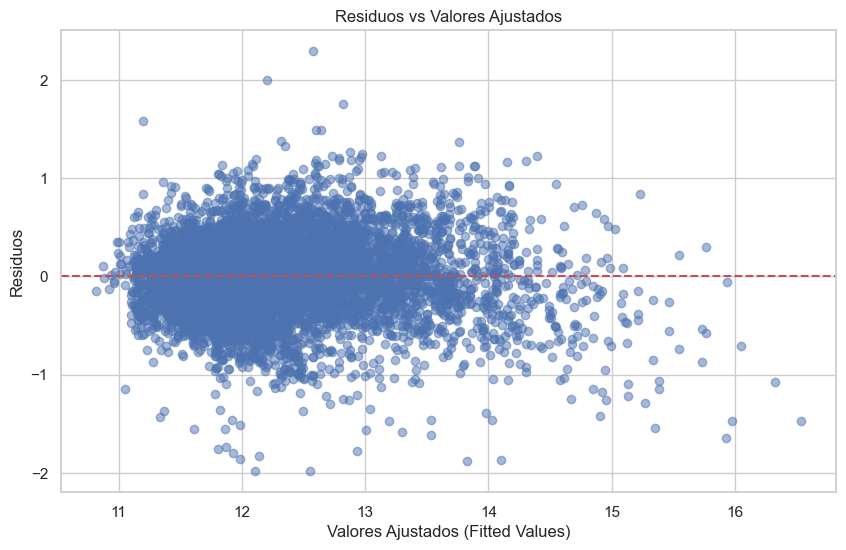

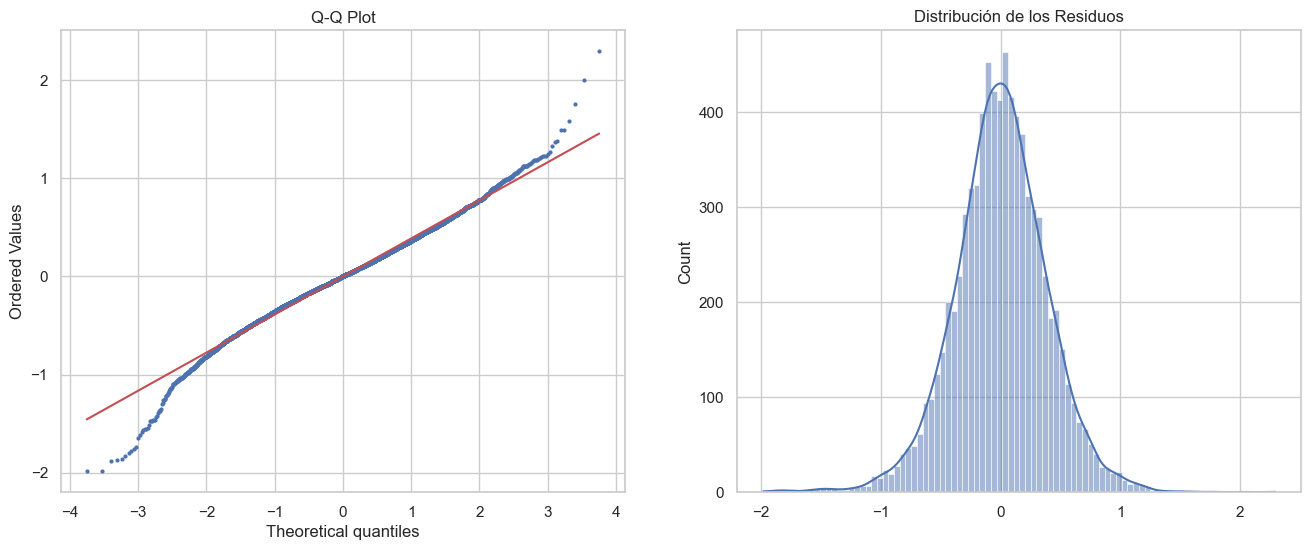

In [14]:
# Recalcular residuos y valores ajustados del modelo OLS (modelo_log_con_dummies)
model = modelo_log_con_dummies
residuals = model.resid
fitted_values = model.fittedvalues

# 1. Residuals vs Fitted (Homocedasticidad y Linealidad)
plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Ajustados (Fitted Values)')
plt.ylabel('Residuos')
plt.title('Residuos vs Valores Ajustados')
plt.show()

# 2. Verificación de Normalidad (Q-Q Plot e Histograma)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

stats.probplot(residuals, dist="norm", plot=ax[0])
ax[0].get_lines()[0].set_marker('o')
ax[0].get_lines()[0].set_markersize(2.0)
ax[0].set_title('Q-Q Plot')

sns.histplot(residuals, kde=True, ax=ax[1])
ax[1].set_title('Distribución de los Residuos')

plt.show()

### Regularización (Ridge & Lasso)


In [15]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X, y)

print("Mejor alpha para Ridge:", ridge_cv.best_params_)
print("Mejor R2 para Ridge:", ridge_cv.best_score_)

# Lasso Regression
lasso = Lasso()
# Usamos alphas pequeños porque Lasso puede llevar coeficientes a cero
lasso_params = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X, y)

print("Mejor alpha para Lasso:", lasso_cv.best_params_)
print("Mejor R2 para Lasso:", lasso_cv.best_score_)


Mejor alpha para Ridge: {'alpha': 0.01}
Mejor R2 para Ridge: 0.5546183515841516
Mejor alpha para Lasso: {'alpha': 0.0001}
Mejor R2 para Lasso: 0.5546183966194176


### Validación Cruzada 

In [ ]:
from sklearn.model_selection import cross_val_score

# Usamos el mejor estimador de Ridge encontrado anteriormente
best_model = ridge_cv.best_estimator_

# Cross-Validation para R2
cv_scores = cross_val_score(best_model, X, y, cv=10, scoring='r2')

print("Resultados de Validación Cruzada (R2):")
print(cv_scores)
print(f"R2 Promedio: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# Cross-Validation para MAE (negativo en sklearn)
cv_mae = cross_val_score(best_model, X, y, cv=10, scoring='neg_mean_absolute_error')
print(f"MAE Promedio: {-np.mean(cv_mae):.4f}")

Resultados de Validación Cruzada (R2):
[0.48331305 0.57923521 0.57100019 0.4524131  0.58033805 0.5225504
 0.59378793 0.63355521 0.64526793 0.5823149 ]
R2 Promedio: 0.5644 (+/- 0.0582)
MAE Promedio: 148857.6494
